In [1]:
### ATOC5860 Application Lab #2 - ATOC7500_applicationlab2_AR1_Nstar
### Written by Jennifer Kay (CU), Elizabeth Maroon (CU), and Hannah Zanowski (CU)
### Last updated September 23, 2020

##LEARNING GOALS:
##1) Calculate the autocorrelation at a range of lags using two methods available in python (np.correlate, dot products)
##2) Estimate the effective sample size (N*) using the lag-1 autocorrelation
##3) Evaluate the influence of changing the sampling frequency on the autocorrelation and on N*.

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xarray
import pandas as pd   ##pandas reads in .csv.
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
sns.set_style('whitegrid')  ###  change away from grey grid (seaborn default) to white grid

In [2]:
## Read in the data
filename = 'christman_2016.csv'
data=pd.read_csv(filename,sep=',')
data.head()

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,42370,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,42370,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,42370,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,42370,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,42370,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0


minimum data value:  -14.3
maximum data value:  97.6


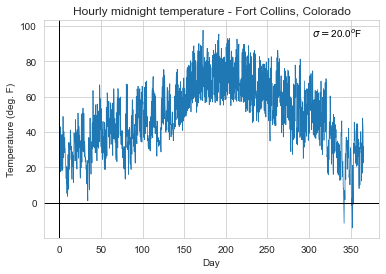

In [20]:
## Plot midnight temperature data for Fort Collins, Colorado
X=data['temp_F']
X_daily=X[::6] ## sample the hourly data every 24 hours [12::24][::2] for noon
print('minimum data value: ',X_daily.min())
print('maximum data value: ',X_daily.max())
xindex = (np.arange(0,np.size(X),1))/24.
xindex_daily=xindex[::6] ## sample the index every 24 hours [12::24][::2] for noon
plt.plot(xindex_daily, X_daily, linewidth = 0.75)
v = np.std(X_daily)
plt.text(0.95, 0.925,'$\sigma = $' + str(np.round(v)) + '$^o$F', ha='right', transform=plt.gca().transAxes, color = 'k')
ymin, ymax = plt.ylim();
xmin, xmax = plt.xlim();
lines = plt.plot((xmin, xmax),(0, 0),(0, 0),(ymin, ymax));
plt.setp(lines,color='black', linewidth=1);
plt.ylim((ymin, ymax));
plt.xlim((xmin, xmax));
plt.ylabel('Temperature (deg. F)');
plt.xlabel('Day');
plt.title('Hourly midnight temperature - Fort Collins, Colorado');

In [26]:
print(X_daily)
print(xindex_daily)

0        7.0
6        3.5
12      31.6
18      21.0
24      18.6
        ... 
8754    43.5
8760    40.9
8766    22.5
8772    31.9
8778    23.9
Name: temp_F, Length: 1464, dtype: float64
[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.6525e+02 3.6550e+02 3.6575e+02]


In [21]:
#Find the lag-one autocorrelation (AR1)
tseries=X_daily
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
n=len(tseries)         ## calculate the length of the timeseries
lag=1                  ## warning: you cannot change this to be a negative lag. 
                       ## this cell does not work for negative lags - Can you see why?

## remove the mean
tseries1=tseries-mean

##Create two timeseries of the data at t=t1 and t=t2
t1_m=tseries1[0:-1*lag]
t2_m=tseries1[lag:]
# print(t1_m)
# print(t2_m)

#Method #1
#Calculate the autocorrelation using numpy correlate lagN
lagNauto_np=np.correlate(t1_m,t2_m,mode='valid')/(n-lag)/(sigma**2)
print('lag',lag,'autocorrelation np.correlate:',round(lagNauto_np[0],3))

#Method #2 - direct calculation
#Calculate the autocorrelation using numpy dot
## (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
lagNauto=np.dot(t1_m,t2_m)/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'autocorrelation direct calc:',round(lagNauto,3))

if lag==1: alpha=lagNauto

lag 1 autocorrelation np.correlate: 0.762
lag 1 autocorrelation direct calc: 0.762


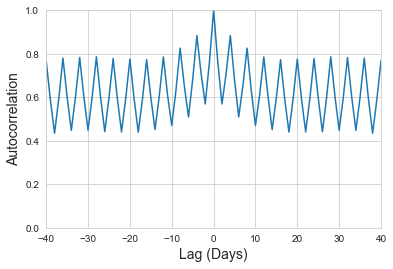

In [27]:
# Calculate the autocorrelation at all lags and plot it
# Is it symmetric about 0 lag?  Should it be? (hint: the answer is yes)
tseries1=tseries-mean
half=int(len(tseries)/2)
lags=np.arange(-1*half,half,1.)
#print(len(tseries1))
#print(len(lags))
#print(len(np.correlate(tseries1,tseries1,mode='same')))
autocorrelation_function=np.correlate(tseries1,tseries1,mode='same')/(n-np.abs(lags))/sigma**2  ##Eq. 67 divided by variance
# autocorrelation_function=np.dot(tseries1,tseries1)/(n-np.abs(lags))/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance

plt.plot(range(-1*half,half),autocorrelation_function)
plt.xlim([-40,40]);
plt.ylim([0.0,1.0]);
plt.xlabel('Lag (Days)',fontsize=14);
plt.ylabel('Autocorrelation',fontsize=14);
# print(autocorrelation_function)

In [28]:
## Calculate the effective sample size (N*) for this data 
## Compare your estimate of the number of independent samples (N*) with the number of samples 
## in your original data (N)
N=len(tseries)
print('# samples, N: ',N)
print('lag-1 autocorrelation: ',round(alpha,2))
print('#independent samples, N*: ',round((1-np.abs(alpha))/(1+np.abs(alpha))*N,0)) ## Chapter 2 Barnes Eq. 88
## Note that the value of the autocorrelation used in Eq. 88 should be the absolute value otherwise
## if alpha is negative you end up with more independent samples than original samples

# samples, N:  1464
lag-1 autocorrelation:  0.76
#independent samples, N*:  198.0


In [24]:
alpha

0.7621142191583926